In [10]:
%%HTML
<style> code {background-color : pink !important;} </style>

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

In [14]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

#    Camera calibration
#    Distortion correction
#    Color/gradient threshold
#    Perspective transform

#    Detect lane lines
#    Determine the lane curvature

def calibrate_undistort():

    # prepare object points
    nx = 8#TODO: enter the number of inside corners in x
    ny = 6#TODO: enter the number of inside corners in y
    
    objpoints = []
    imgpoints = []

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # x, y coordinates

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True: # meaning that we found chessboard corners
      imgpoints.append(corners)
      objpoints.append(objp)

      img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
      plt.imshow(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)


def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

    # Return the resulting image and matrix
    return warped, M


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output



In [3]:
image = cv2.imread("signs_vehicles_xygrad.png")
plt.imshow(image)

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

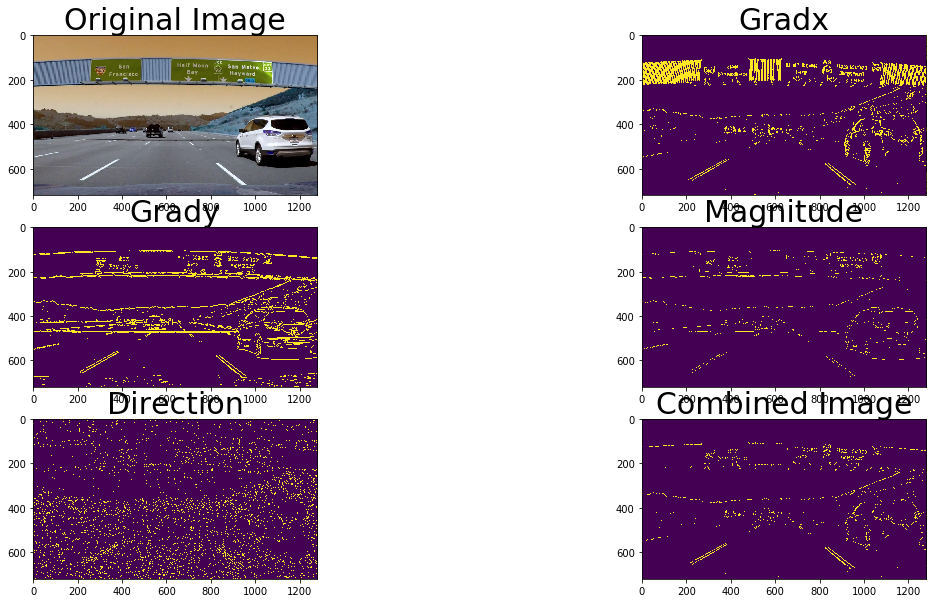

In [40]:
%matplotlib inline

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(70, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.85, 1.05))

combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[(gradx == 1) & (grady == 1)] = 1

#cv2.imshow('image', image)
#cv2.imshow('image', image)
#cv2.imshow('image', image)
#cv2.imshow('image', image)
#cv2.imshow('combined', combined)

f, ( (ax1, ax2), (ax3, ax4), (ax5, ax6) ) = plt.subplots(3, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(gradx)
ax2.set_title('Gradx', fontsize=30)
ax3.imshow(grady)
ax3.set_title('Grady', fontsize=30)
ax4.imshow(mag_binary)
ax4.set_title('Magnitude', fontsize=30)
ax5.imshow(dir_binary)
ax5.set_title('Direction', fontsize=30)
ax6.imshow(combined)
ax6.set_title('Combined Image', fontsize=30)